# Introduction
Neural networks have become a powerful tool for automating complex tasks in crystallography, including PXRD data analysis. For example, [indexing](https://scripts.iucr.org/cgi-bin/paper?vb5020), [crystallite size and scale factor](https://www.nature.com/articles/s41524-021-00542-4) determination, as well as [crystal system and space group](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.245120) [classification](https://journals.iucr.org/m/issues/2017/04/00/fc5018/index.html). There are many more examples in the literature! In future posts, we'll look at how to train our own neural networks for analysing PXRD data. However, before we get there, we'll need a large volume of PXRD against which they can be trained.

To the best of my knowledge, there is no extant database of experimental PXRD patterns. However, there are several databases, such as the [COD](http://www.crystallography.net/cod/), CCDC's [CSD](https://www.ccdc.cam.ac.uk/solutions/software/csd/) and ICDD's [PDF](https://www.icdd.com/), which provide experimental crystal structures. These databases, which contain hundreds of thousands of crystal structures can then be used to calculate diffraction patterns. The CSD has a [python API](https://downloads.ccdc.cam.ac.uk/documentation/API/) which allows PXRD data to be generated for each of the entries in the database. However, this is not optimised to run quickly, and as such, PXRD data would need to be generated in advance.

In this post, we'll look at how we can efficiently calculate large numbers of diffraction patterns _on-the-fly_ whilst training neural networks. By writing our own code to generate synthetic PXRD data, we will also be able to implement various _data augmentation_ transformations. Such transformations make the calculated PXRD data look different from the perspective of a machine learning algorithm, but could still plausibly be produced by the same underlying material. This will help to make our future neural networks more robust and able to be applied to real-world diffraction data.



# Synthetic Diffraction data using the PowCod database

I used the [PowCod database](https://www.researchgate.net/publication/273507012_QUALX20_A_qualitative_phase_analysis_software_using_the_freely_available_database_POW-COD) produced by the [Bari group](https://www.ba.ic.cnr.it/softwareic/qualx/powcod-download/) as the source for the diffraction data. This database is based on the COD, and for each entry, a Powder X-ray diffraction pattern has been calculated. This is saved in PowCod in the form of the Miller indices of each reflection, the associated intensity, the d-spacing and other relevant information (e.g. multiplicity etc). Being able to read in this information directly, rather than having to calculate this for each of the crystal structures makes this work significantly easier.

As described earlier, PowCod provides lots of information. Most pertinent for this work is the unit cells, space groups, Miller indices and associated intensities for all of the crystal structures. In the next sections, we'll look at how I filtered the PowCod database, and then discuss the PyTorch-based code I've written to generate relatively realistic looking PXRD data on-the-fly using my GPU.

I've included several methods of data augmentation:

- Modification of unit cells to simulate thermal expansion / contraction
- Modification of intensities using the March-Dollase method to simulate preferred orientation effects
- Modification of peak shapes, broadening and asymmetry to simulate different crystallite sizes/strains and instrumentation
- Modification of zero point errors to simulate different instruments
- Modification of noise to simulate different experimental data collection times / sample sizes

## Filtering PowCod data
The PowCod database, which can be obtained [here](https://www.ba.ic.cnr.it/softwareic/qualx/powcod-download/), is made up of several .sql files which need to be parsed to extract the desired information. In our case, what we are after is:

- Unit cells
- Crystal systems
- Space groups
- Miller indices
- Intensities

We'll probably also need to use some additional information to help us along the way, for example, the d-spacing of the reflections.

As the files total only around 5.5 GB, I used pandas to read the database into memory and extract the information needed. I pickled the resultant dataframe to enable it to be more easily read in the future.

In [4]:
#| code-fold: false
import pandas as pd
import os


def read_powcod_sql():
    import sqlite3
    con = sqlite3.connect('cod2205.sq')
    df = pd.read_sql_query('SELECT * FROM id',con)
    con2 = sqlite3.connect('cod2205.sq.info')
    df2 = pd.read_sql_query('SELECT * FROM info',con2)

    df.id = pd.to_numeric(df.id)
    df2.id = pd.to_numeric(df2.id)

    combined = df.merge(df2, left_on="id", right_on="id")
    return combined

if os.path.isfile("combined.pkl"):
    combined = pd.read_pickle("combined.pkl")
else:
    combined = read_powcod_sql()
    print(combined.columns)
    combined = combined[["spacegroup_x", "a", "b", "c", "alpha", "beta",
                    "gamma", "volume", "h", "k", "l", "nd", "dvalue",
                    "intensita", "type", "id"]]
    combined.to_pickle("combined.pkl")

Let's have a look at what we've got:

In [5]:
combined

,spacegroup_x,a,b,c,alpha,beta,gamma,volume,h,k,l,nd,dvalue,intensita,type,id
0,C m c m,0.0000,0.0000,0.0000,0.0,0.000,0.0,738.078,0,0,0,1,0.000000,0.000000,Orthorhombic,1010866
1,I 4/m m m,0.0000,0.0000,0.0000,0.0,0.000,0.0,388.473,0,0,0,1,0.000000,0.000000,Tetragonal,6000382
2,P -1,0.0000,0.0000,0.0000,0.0,0.000,0.0,429.928,0,0,0,1,0.000000,0.000000,Triclinic,6000073
3,P -3,0.0000,0.0000,0.0000,0.0,0.000,0.0,1221.297,0,0,0,1,0.000000,0.000000,Trigonal (hexagonal axes),6000152
4,P 1,0.0000,0.0000,0.0000,0.0,0.000,0.0,552.983,0,0,0,1,0.000000,0.000000,Cubic,6000430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458155,P 1 21 1,6.6330,15.4171,11.9417,90.0,103.335,90.0,1188.257,"0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,0,1,0,1,1,1,1,1,...","0,1,2,0,2,0,1,1,0,1,0,2,0,1,2,3,1,2,2,2,3,3,0,...","1,1,0,0,1,-1,0,-1,2,2,1,0,-2,1,-1,1,-2,2,1,-2,...",499,"11.619700,9.279300,7.708500,6.454200,6.423600,...","1000.000000,62.638200,82.940500,3.929300,0.067...",Monoclinic,4344045
458156,C 1 2/m 1,21.2287,17.8117,12.3055,90.0,124.759,90.0,3822.662,"1,1,0,2,0,2,0,2,1,3,2,2,1,1,3,3,1,2,4,2,0,4,1,...","1,1,0,0,2,0,2,2,1,1,2,0,3,1,1,1,3,0,0,2,0,0,3,...","0,-1,1,-1,0,0,1,-1,1,-1,0,-2,0,-2,0,-2,-1,1,-1...",498,"12.461500,10.123800,10.109700,9.999700,8.90580...","1000.000000,1.459300,384.189200,186.432500,88....",Monoclinic,4123491
458157,C 1 2/m 1,21.5314,18.0366,12.3918,90.0,124.872,90.0,3948.216,"1,1,0,2,0,2,0,2,1,3,2,2,1,3,1,3,1,2,4,2,0,4,1,...","1,1,0,0,2,0,2,2,1,1,2,0,3,1,1,1,3,0,0,2,0,0,3,...","0,-1,1,-1,0,0,1,-1,1,-1,0,-2,0,0,-2,-2,-1,1,-1...",498,"12.620300,10.213500,10.166600,10.122700,9.0183...","1000.000000,0.425500,401.199700,131.443500,109...",Monoclinic,4123492
458158,I -4 2 m,10.2400,10.2400,9.6520,90.0,90.000,90.0,1012.086,"1,1,2,0,2,1,2,2,3,3,1,2,3,3,2,4,3,0,4,3,4,1,4,...","1,0,0,0,1,1,2,0,1,0,0,2,2,1,1,0,3,0,1,0,2,1,0,...","0,1,0,2,1,2,0,2,0,1,3,2,1,2,3,0,0,4,1,3,0,4,2,...",302,"7.240800,7.023700,5.120000,4.826000,4.137400,4...","435.793700,1000.000000,156.773800,74.174400,1....",Tetragonal,1508227


In [6]:
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd,id
count,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,458160.000000,4.581600e+05
mean,12.505100,13.372528,16.330272,89.503372,95.199651,90.906179,3178.613746,454.593930,4.604041e+06
std,6.874009,6.655914,8.092967,8.326557,11.649541,10.924374,6384.755145,119.026662,2.281053e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+06
25%,8.282900,9.153000,11.279975,90.000000,90.000000,90.000000,1089.974000,498.000000,2.221300e+06
50%,10.780000,12.130000,15.169000,90.000000,92.430000,90.000000,1976.458000,499.000000,4.302406e+06
75%,14.703000,16.140000,19.860000,90.000000,101.688000,90.000000,3562.973750,500.000000,7.046806e+06
max,189.800000,150.000000,475.977800,150.172000,173.895000,149.900000,740478.188000,500.000000,9.016730e+06


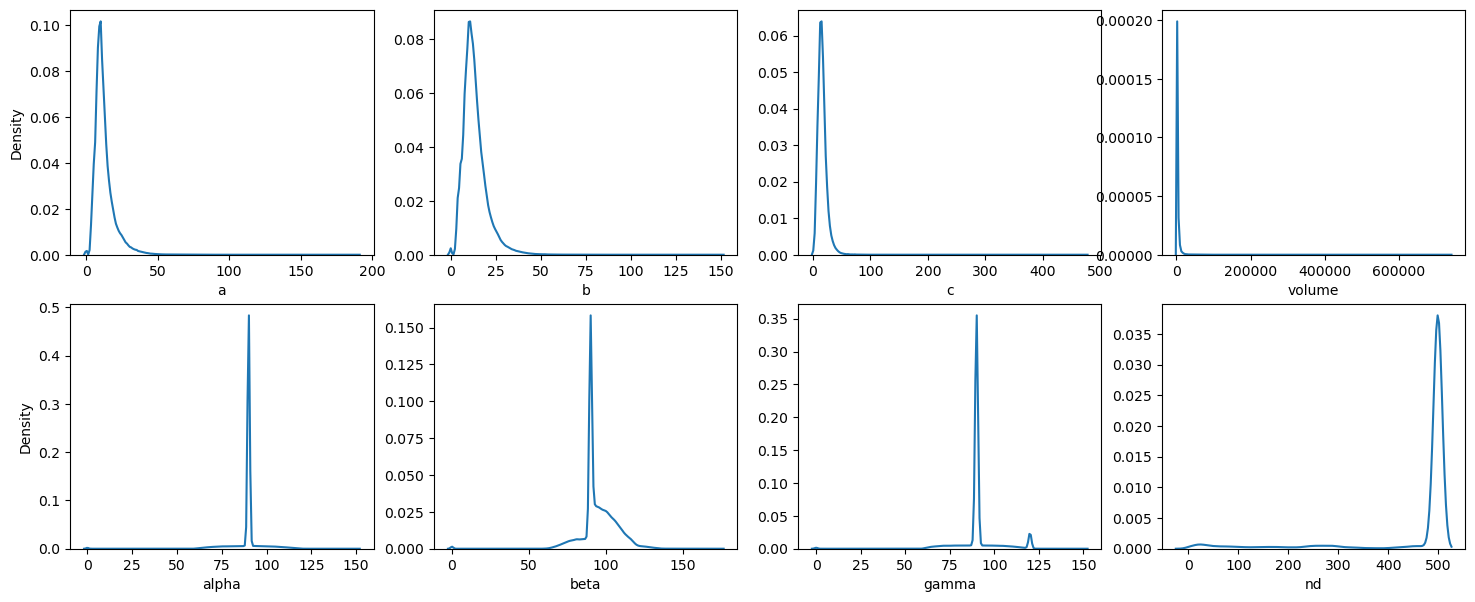

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, figsize=(18,7))
sns.kdeplot(combined.a, ax=ax[0][0])
sns.kdeplot(combined.b, ax=ax[0][1])
sns.kdeplot(combined.c, ax=ax[0][2])
sns.kdeplot(combined.volume, ax=ax[0][3])
sns.kdeplot(combined.alpha, ax=ax[1][0])
sns.kdeplot(combined.beta, ax=ax[1][1])
sns.kdeplot(combined.gamma, ax=ax[1][2])
sns.kdeplot(combined.nd, ax=ax[1][3])
for i in range(2):
    for j in range(3):
        ax[i][j+1].set_ylabel("")
plt.show()

We're starting off with 458k samples, but a lot of these won't be useful for us. I'm choosing to focus on materials with relatively small unit cells, and attempting to generate realistic looking _laboratory_ diffraction data.

We can see that some unit cells are listed as having zero volume, and have a value of 0 for the unit cell lengths and angles. Our goal of modifying unit cells and using them to generate the diffraction data as a form of data augmentation means that these entries are not useful to us, so we'll need to remove them. We can also see that there are some monstrous unit cells in there, with volumes of >700,000 Å³!

To make things manageable for future machine learning projects, we're going to set limits on the allowable unit cell dimensions and volumes. Let's set the lower and upper limits for volume to 400 and 4000 Å³ respectively, and set the maximum unit cell length to 50 Å. We can also see some unusual looking unit cell angles, so I'm going to trim entries with cell angles below 60 and above 120 degrees (keeping 120 degrees is important to ensure we keep hexagonal unit cells).

Eventually, we're going to generate diffraction data. I've chosen to focus on realistic looking laboratory diffraction data, and hence I'm choosing to work in the (arbirarily chosen!) range  4 - 44 ° $2\theta$ with Cu K-α1 radiation. We'll want to ensure that there are at least a few easily detectable peaks within this chosen range. I'll set the lower bound for this as 10.

In [8]:
#| code-fold: false
min_volume = 400
max_volume = 4000
max_cell_length = 50
min_cell_angle = 60
max_cell_angle = 120
min_data_angle = 4
max_data_angle = 44
wavelength = 1.54056
min_detectable_peaks_in_range = 10

### Unit cell dimensions and volume

Let's first filter by the unit cell restrictions on volume, lengths and angles. We can also filter by the number of d-spacings (in the column ```nd```) though we will need to come back to this again later to check that the remaining reflections are both in the range desired and also have reasonable intensities.

In [9]:
combined = combined[(combined.volume <= max_volume) & (combined.volume >= min_volume)]
combined = combined[(combined.a != 0) & (combined.b != 0) & (combined.c != 0)]
combined = combined[(combined.a <= max_cell_length) & (combined.b <= max_cell_length) & (combined.c <= max_cell_length)]
combined = combined[(combined.alpha >= min_cell_angle) & (combined.alpha <= max_cell_angle)]
combined = combined[(combined.beta >= min_cell_angle) & (combined.beta <= max_cell_angle)]
combined = combined[(combined.gamma >= min_cell_angle) & (combined.gamma <= max_cell_angle)]
combined = combined[(combined.nd >= min_detectable_peaks_in_range)]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd,id
count,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,324333.000000,3.243330e+05
mean,10.992746,12.400612,15.034673,89.719327,94.956107,90.499324,1849.638022,477.448866,4.549946e+06
std,4.372923,4.840500,5.626536,7.474114,9.913211,9.476333,931.743127,81.543710,2.265363e+06
min,2.808500,2.820000,2.718100,60.019000,60.130000,60.000000,400.059000,16.000000,1.000000e+06
25%,8.236400,9.237500,11.247500,90.000000,90.000000,90.000000,1085.857000,498.000000,2.219163e+06
50%,10.114500,11.585500,14.365300,90.000000,93.216000,90.000000,1699.288000,499.000000,4.129720e+06
75%,12.609000,14.506900,17.908600,90.000000,101.601000,90.000000,2515.215000,500.000000,7.047435e+06
max,49.953000,49.977000,49.944000,119.990000,120.000000,120.000000,3999.991000,500.000000,9.016729e+06


That's a fairly significant reduction in the number of samples - the size of the dataset has gone down by over 100k! However, hopefully we've now gotten rid of most of the really odd or unusable samples in the dataset, and the remaining filtering won't have such a drastic effect on the remaining entries.

Let's now replot the kernel density plots we saw earlier and see how things look after the filtering.

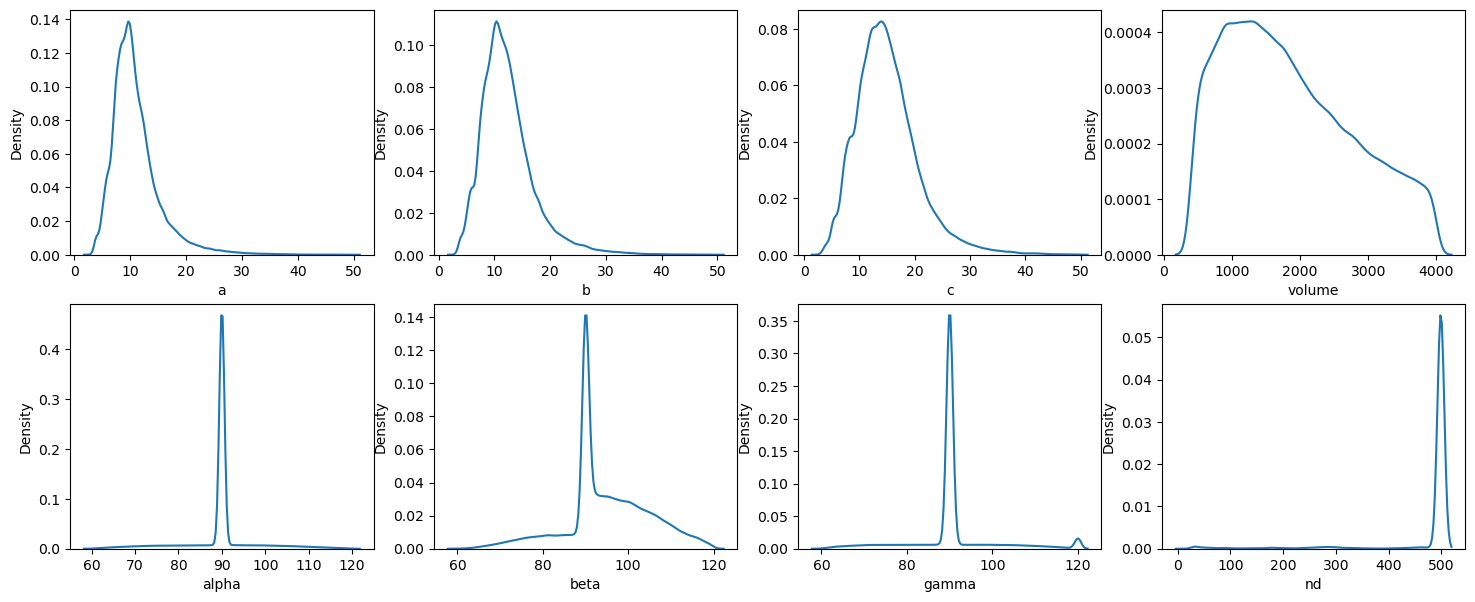

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(18,7))
sns.kdeplot(combined.a, ax=ax[0][0])
sns.kdeplot(combined.b, ax=ax[0][1])
sns.kdeplot(combined.c, ax=ax[0][2])
sns.kdeplot(combined.volume, ax=ax[0][3])
sns.kdeplot(combined.alpha, ax=ax[1][0])
sns.kdeplot(combined.beta, ax=ax[1][1])
sns.kdeplot(combined.gamma, ax=ax[1][2])
sns.kdeplot(combined.nd, ax=ax[1][3])
plt.show()

Things look a bit nicer now! Just out of interest, we'll take a quick look at the distribution of crystal systems and space groups. Other work looking at the CSD and other databases has shown a significant imbalance in the number of crystal structures adopting each crystal system and indeed space group.

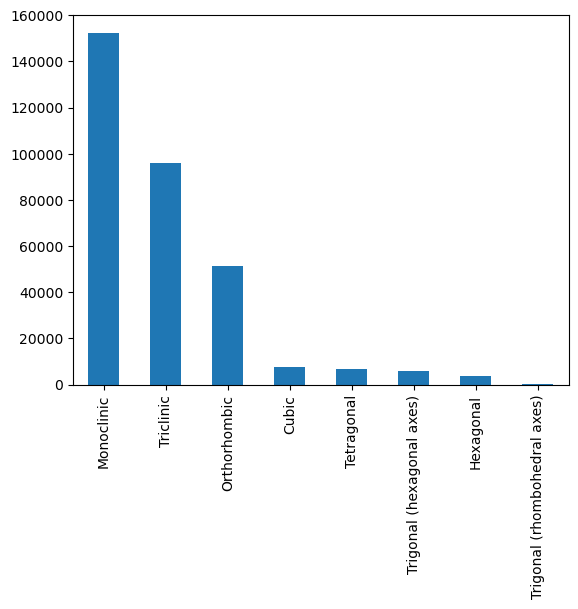

In [11]:
#| code-fold: true
combined.type.value_counts().sort_values().iloc[::-1].head(20).plot.bar()
plt.show()

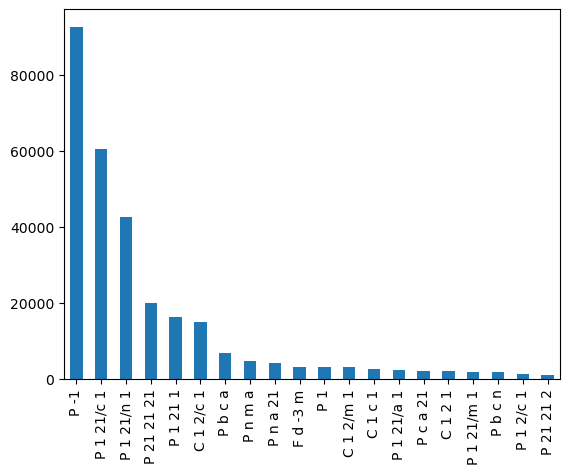

In [12]:
#| code-fold: true
combined.spacegroup_x.value_counts().sort_values().iloc[::-1].head(20).plot.bar()
plt.show()

Unsurprisingly, we see that some space groups are much more highly represented than others. If we decide to try crystal system, space group or extinction symbol classification using this data, we will need to keep this fairly severe class imbalance in mind!

For convenience for future work, it'd be good to convert these labels into their international tables numbers. Let's write a quick function to do that, getting rid of any entries that have unknown space groups, or space group labels that are otherwise difficult to interpret.

In [13]:
from pymatgen.symmetry import groups
import numpy as np

symbol_to_num = {}
for i, s in enumerate(np.unique(combined.spacegroup_x.to_numpy())):
    try:
        g = groups.SpaceGroup(s)
        symbol_to_num[s] = g.int_number
    except:
        symbol_to_num[s] = -1

def label_SGs(sg):
    return symbol_to_num[sg]

combined["sg_number"] = combined.spacegroup_x.apply(label_SGs)
combined = combined[combined.sg_number > 0]
combined.sg_number.describe()

count    323694.000000
mean         24.984507
std          44.618451
min           1.000000
25%           2.000000
50%          14.000000
75%          15.000000
max         230.000000
Name: sg_number, dtype: float64

We lost <1000 entries in that step, which is good news!

### Diffraction data

We can now turn our attention to the diffraction data - the intensities, Miller indices and d-spacings. Some of the entries will have a huge number of peaks, some will have very few. To start with, I'm choosing to exclude samples that have reflections _below_ the bottom of our data range. I also want to ensure that there is still at least one peak _above_ the top end of our data range which ensures that we aren't missing any data _inside_ our chosen data range.

Our dataframe contains the d-spacings for the observed reflections, so using Bragg's law we can easily convert the angular range bounds into d-spacings, and then apply the filtering just described.

In [11]:
import numpy as np

d_from_tt = lambda x: wavelength/(2*np.sin(np.deg2rad(x)/2))
tt_from_d = lambda x: 2*np.rad2deg(np.arcsin(wavelength/(2*x)))
max_d = d_from_tt(min_data_angle)
min_d = d_from_tt(max_data_angle)
print("Wavelength:", wavelength)
print(f"Minimum angle = {min_data_angle}  : Maximum d-spacing = {max_d:.3f}")
print(f"Maximum angle = {max_data_angle} : Minimum d-spacing = {min_d:.3f}")

Wavelength: 1.54056
Minimum angle = 4  : Maximum d-spacing = 22.071
Maximum angle = 44 : Minimum d-spacing = 2.056


In [12]:
def d_spacing_limits(x, min_d_spacing=1, max_d_spacing=100):
    d = list(filter(None, x.strip().split(",")))
    d = [float(i) for i in d]
    if len(d) == 0:
        return False
    else:
        if d[-1] > min_d_spacing:
            return False
        if d[0] > max_d_spacing:
            return False
        return True

combined["d_spacing_filter"] = combined.dvalue.apply(d_spacing_limits, args=(min_d, max_d))

In [13]:
combined = combined[combined["d_spacing_filter"] == True]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd,id,sg_number
count,294047.000000,294047.000000,294047.000000,294047.000000,294047.000000,294047.000000,294047.000000,294047.000000,2.940470e+05,294047.000000
mean,10.880480,12.250730,14.660952,89.810688,95.496771,90.697710,1761.181410,475.436522,4.502841e+06,27.194466
std,4.407073,4.930788,5.572797,6.735834,9.633053,8.870661,911.606182,85.121247,2.291774e+06,46.176416
min,2.808500,2.825500,2.718100,60.019000,60.130000,60.000000,400.059000,16.000000,1.000000e+06,1.000000
25%,8.104550,9.061050,10.951000,90.000000,90.000000,90.000000,1033.725000,498.000000,2.214880e+06,4.000000
50%,9.900700,11.252000,13.876500,90.000000,93.612000,90.000000,1587.395000,499.000000,4.122961e+06,14.000000
75%,12.467950,14.239950,17.401100,90.000000,101.996000,90.000000,2354.773000,500.000000,7.047926e+06,19.000000
max,45.366000,48.809000,49.494500,119.990000,120.000000,120.000000,3999.991000,500.000000,9.016729e+06,230.000000


We are down to just shy of 300k samples now, with one last bit of filtering to apply. Lastly, we'll ensure that we have sufficient easily detectable peaks within our data range. Do to this, we need to look at the intensities:

In [14]:
combined.intensita

11        1000.000000,293.781700,0.932900,880.099700,350...
12        344.517500,136.663800,113.543400,41.743900,4.9...
13        480.841100,1000.000000,345.837700,13.887000,72...
14        6.550100,7.094000,99.801200,1000.000000,642.20...
17        2.707700,223.647400,1000.000000,119.345700,113...
                                ...                        
458148    191.292600,19.724900,41.216500,169.019100,150....
458151    1000.000000,782.379000,202.061600,29.027900,13...
458155    1000.000000,62.638200,82.940500,3.929300,0.067...
458158    435.793700,1000.000000,156.773800,74.174400,1....
458159    884.735400,207.638600,175.487800,594.721200,42...
Name: intensita, Length: 294047, dtype: object

Intensities are stored as a string of comma separated values, with each pattern scaled to a maximum intensity of 1000. Next we should ensure that in our chosen data range, the intensities that are present are actually strong enough to be observed. Let's say we want the minimum intensity in our data range to be 0.5 % of the maximum intensity. As such, there should have at least $N$ intensities in our range with a value greater than 5. As discussed earlier, I've chosen to set $N = 10$.

In [15]:
def n_peaks_in_range(dspacing, intensity, min_intensity=5):
    dspacing = list(filter(None, dspacing.strip().split(",")))
    dspacing = np.array([float(i) for i in dspacing])
    intensity = list(filter(None, intensity.strip().split(",")))
    intensity = np.array([float(i) for i in intensity])
    intensity = intensity[dspacing >= min_d]
    return (intensity > min_intensity).sum()

combined["n_detectable_peaks_in_range"] = combined.apply(lambda x: n_peaks_in_range(x.dvalue, x.intensita), axis=1)
combined["n_detectable_peaks_in_range"].describe()

count    294047.000000
mean        113.481430
std          59.305561
min           0.000000
25%          72.000000
50%         107.000000
75%         149.000000
max         386.000000
Name: n_detectable_peaks_in_range, dtype: float64

As we can see, some of the patterns we might generate would have very few or no easily detectable peaks in our chosen data range. As our final filtering step, we'll get rid of them, leaving us with our final filtered dataset.

In [16]:
combined = combined[combined.n_detectable_peaks_in_range >= min_detectable_peaks_in_range]
combined.describe()

,a,b,c,alpha,beta,gamma,volume,nd,id,sg_number,n_detectable_peaks_in_range
count,288123.000000,288123.000000,288123.000000,288123.000000,288123.000000,288123.000000,288123.000000,288123.000000,2.881230e+05,288123.000000,288123.000000
mean,10.915994,12.314144,14.769507,89.806797,95.609645,90.698470,1780.427861,484.062508,4.493060e+06,23.272384,115.697018
std,4.439603,4.955456,5.568620,6.804673,9.698929,8.939179,909.067811,60.494039,2.259233e+06,37.387276,57.842270
min,2.808500,2.825500,2.760000,60.019000,60.130000,60.000000,400.059000,30.000000,1.000000e+06,1.000000,10.000000
25%,8.099250,9.133100,11.122850,90.000000,90.000000,90.000000,1054.453000,498.000000,2.216278e+06,4.000000,75.000000
50%,9.925000,11.332000,13.984900,90.000000,93.924000,90.000000,1608.534000,499.000000,4.122969e+06,14.000000,108.000000
75%,12.542100,14.337000,17.492400,90.000000,102.190000,90.000000,2378.520500,500.000000,7.045938e+06,15.000000,151.000000
max,45.366000,48.809000,49.494500,119.990000,120.000000,120.000000,3999.991000,500.000000,9.016729e+06,230.000000,386.000000


### Saving the filtered data

Now that we've filtered our data to our requirements, the last thing to do is save the relevant information in numpy arrays which can then be quickly and easily loaded from disk when needed.

The arrays to be saved will contain:

- Unit cells
- Crystal systems
- Miller indices
- Peak intensities
- Space groups
- COD IDs in case we want to look up a particular crystal structure

As the number of peaks in each pattern is different, the Miller indices and Peak intensity arrays will need padding up to the maximum number, which is 500.

In [18]:
def get_array(x, dtype=np.float32):
    data = np.zeros(500, dtype=dtype)
    x = list(filter(None, x.strip().split(",")))
    x = np.array(x, dtype=dtype)
    data[:len(x)] = x
    return data

h = combined.h.apply(get_array, args=(np.int64,))
k = combined.k.apply(get_array, args=(np.int64,))
l = combined.l.apply(get_array, args=(np.int64,))
intensities = combined.intensita.apply(get_array, args=(np.float32,))

intensities = np.vstack(intensities)
h = np.vstack(h)
k = np.vstack(k)
l = np.vstack(l)
hkl = np.dstack([h,k,l])

unit_cell = combined[["a","b","c","alpha","beta","gamma"]].to_numpy()
crystal_systems, crystal_systems_numeric = np.unique(combined.type.to_numpy(), return_inverse=True)
space_group_number = combined.sg_number.to_numpy()
cod_id = combined.id.to_numpy()
print(crystal_systems)

Now we can save everything, as well as a configuration file to keep track of our settings, which we'll save using the ```json``` format.

In [19]:
import json

base_name = f"{min_data_angle}-{max_data_angle}-CuKa1-data_{max_volume}_"
config = {}
config["base_name"] = base_name
config["min_volume"] = min_volume
config["max_volume"] = max_volume
config["max_cell_length"] = max_cell_length
config["min_cell_angle"] = min_cell_angle
config["max_cell_angle"] = max_cell_angle
config["min_data_angle"] = min_data_angle
config["max_data_angle"] = max_data_angle
config["wavelength"] = wavelength
config["min_detectable_peaks_in_range"] = min_detectable_peaks_in_range
config["crystal_systems"] = [x[0]+" = "+str(x[1]) for x in zip(crystal_systems, np.arange(len(crystal_systems)))]

with open("data_config.json", "w") as f:
    json.dump(config, f, indent=4)
np.save(base_name+"unit_cell.npy", unit_cell)
np.save(base_name+"crystal_systems_numeric.npy", crystal_systems_numeric)
np.save(base_name+"space_group_number.npy", space_group_number)
np.save(base_name+"hkl.npy", hkl)
np.save(base_name+"intensities.npy", intensities)
np.save(base_name+"cod_id.npy", cod_id)

# Generating synthetic data

Now that we've filtered down the original PowCod database into the entries that meet the (arbitrary) conditions described earlier, it's time to start thinking about how we can use the information to generate synthetic PXRD data.

I've split this task into:

- Peak positions
- Peak intensities
- Peak shapes
- Noise and background

## Peak positions

Rather than using the d-spacings from the database directly, we are going to make use of the unit cells and Miller indices to calculate the d-spacings (and hence angles) for the reflections. This will allow us to add a small amount of noise to the unit cell dimensions, which serves as a form of data augmentation.

The d-spacing of a given reflection can be calculated using this equation:

$\frac{1}{d^{2}} = X_{hh}h^2 + X_{kk}k^2 + X_{ll}l^2 + X_{hk}hk +X_{hl}hl + X_{kl}kl$

where $X_{nn}$ are elements of the reciprocal space metric tensor.

This means that we will need a function to convert the unit cell dimensions into a matrix representation of the unit cell, invert this to determine the reciprocal lattice matrix and from this obtain the reciprocal lattice metric tensor. Once we have the reciprocal lattice metric tensor, we can calculate the d-spacings quite easily by multiplying with the Miller index array(s). However, one complication is that we want to do this for several samples simultaneously, so need to consider the shapes of our arrays.

Before dealing with that, let's write a function to simulate the effect of temperature changes, by adding a small amount of Gaussian noise to the unit cell dimensions. We will have to consider the crystal system symmetry here in order to ensure that, for example a cubic unit cell, the perturbation to lengths $b$ and $c$ is equal to the pertubation to $a$. The standard deviation of the random noise to be added is going to be set to a default value of 0.05, meaning that the majority of perturbed unit cells should have edges with lengths +/- 0.15 Å from the database values, and angles +/- 0.15 ° (assuming they are allowed to vary by symmetry). This seems reasonable, and should allow us to assume that the fractional coordinates within the unit cells are unaffected, so we don't need to worry about the effect on the relative intensities.

In [14]:
import torch

def get_unit_cell_perturbation(crystal_systems, dtype=torch.float32, stddev=0.05):
    """Generate a perturbation for the unit cell lengths and angles for a given
    crystal system.

    Args:
        crystal_systems (tensor):   Crystal systems for the unit cells.
                                    Shape = (batch)
        dtype (torch.dtype, optional): Defaults to torch.float32.
        stddev (float, optional):   Standard deviation for the gaussian noise.
                                    Defaults to 0.05.

    Returns:
        tensor: A tensors to additively adjust the unit cell lengths and angles
                Shape = (batch, 6)
    """
    batchsize = crystal_systems.shape[0]
    device = crystal_systems.device
    lengths, angles = torch.randn((2, batchsize, 3), device=device, dtype=dtype) * stddev
    cubic = crystal_systems == 0
    hexagonal = crystal_systems == 1
    monoclinic = crystal_systems == 2
    #orthorhombic = crystal_systems == 3 # Don't need to query data for this
    tetragonal = crystal_systems == 4
    triclinic = crystal_systems == 5
    trigonal_h = crystal_systems == 6
    trigonal_r = crystal_systems == 7

    # Cubic, tetragonal, rhombohedral and hexagonal - a and b must be the same
    lengths[:,1] = torch.where(cubic | hexagonal | tetragonal | trigonal_h | trigonal_r,
                            lengths[:,0], lengths[:,1])
    # Cubic and rhombohedral cells - a, b and c must be the same
    lengths[:,2] = torch.where(cubic | trigonal_r, lengths[:,0], lengths[:,2])
    # Rhombohedral and triclinic cells - could change their alpha values
    angles[:,0] = torch.where((trigonal_r | triclinic), angles[:,0], 0.)
    # Triclinic or monoclinic cells could change beta values
    angles[:,1] = torch.where((triclinic | monoclinic), angles[:,1], 0.)
    # Triclinc cells could change gamma
    angles[:,2] = torch.where(triclinic, angles[:,2], 0.)
    # Rhombohedral cells - need to ensure all angles are the same
    angles[:,1] = torch.where(trigonal_r, angles[:,0], angles[:,1])
    angles[:,2] = torch.where(trigonal_r, angles[:,0], angles[:,2])

    return torch.concat([lengths, angles], dim=-1)

Let's check it does what it's meant to!

What we're expecting is that for the unit cell lengths, the perturbation should be the same for each of the edges for cubic and rhombohedral cells, and the perturbation for $a$ and $b$ should be the same for hexagonal and tetragonal cells.

With regards to angles, where the original unit cell is an angle of 90 or 120 degrees, the perturbation should be zero. So we should see a change in the beta value for monoclinic cells, a change for all values of the triclinic unit cells and the same change for each of the angles for rhombohedral cells.

In [15]:
cs_key =  {
    "Cubic" : 0,
    "Hexagonal" :  1,
    "Monoclinic" : 2,
    "Orthorhombic" : 3,
    "Tetragonal" : 4,
    "Triclinic" : 5,
    "Trigonal (hexagonal axes)" : 6,
    "Trigonal (rhombohedral axes)" : 7
}

for c in cs_key.items():
    name, number = c
    perturb = get_unit_cell_perturbation(torch.tensor([[int(number)]]))
    lengths = perturb[:,:3]
    angles = perturb[:,3:]
    print(name, "Length perturbation:", lengths)
    print(name, "Angle perturbation:", angles,"\n")

Cubic Length perturbation: tensor([[0.0120, 0.0120, 0.0120]])
Cubic Angle perturbation: tensor([[0., 0., 0.]]) 

Hexagonal Length perturbation: tensor([[0.0535, 0.0535, 0.0225]])
Hexagonal Angle perturbation: tensor([[0., 0., 0.]]) 

Monoclinic Length perturbation: tensor([[-0.0509,  0.0907, -0.0980]])
Monoclinic Angle perturbation: tensor([[0.0000, 0.0176, 0.0000]]) 

Orthorhombic Length perturbation: tensor([[-0.0788, -0.0403, -0.0860]])
Orthorhombic Angle perturbation: tensor([[0., 0., 0.]]) 

Tetragonal Length perturbation: tensor([[-0.0156, -0.0156, -0.0144]])
Tetragonal Angle perturbation: tensor([[0., 0., 0.]]) 

Triclinic Length perturbation: tensor([[-0.0154, -0.0387,  0.0159]])
Triclinic Angle perturbation: tensor([[ 0.0273, -0.0582, -0.0836]]) 

Trigonal (hexagonal axes) Length perturbation: tensor([[-0.0063, -0.0063,  0.0845]])
Trigonal (hexagonal axes) Angle perturbation: tensor([[0., 0., 0.]]) 

Trigonal (rhombohedral axes) Length perturbation: tensor([[-0.0002, -0.0002, 

Looks good to me. We now need to start writing functions to generate our lattice matrix, reciprocal lattice matrix and reciprocal lattice metric tensor. We can then use these in conjunction with the Miller indices to determine the reflection d-spacings.

Given that we are modifying unit cells, it's probably sensible to check that the perturbed unit cells are valid. We can do that by calculating the volume of the unit cells, with invalid unit cells returning a volume of zero.

In [16]:
def get_lattice_matrix(unit_cell_dimensions):
    """calculate a lattice matrix from unit cell dimensions

    Args:
        unit_cell_dimensions (tensor):  The unit cell dimensions. Lengths in
                                        angstroms, angles in degrees.
                                        Shape = (batch, 6)

    Returns:
        tensor: The matrix representation of the unit cells.
                Shape = (batch, 3, 3)
    """
    pi_over_180=0.017453292519943295
    a, b, c = unit_cell_dimensions[:,:3].T
    cosal, cosbe, cosga = torch.cos(unit_cell_dimensions[:,3:]*pi_over_180).T
    sinal, sinbe = torch.sin(unit_cell_dimensions[:,3:-1]*pi_over_180).T
    # Sometimes rounding errors cause |values| slightly > 1.
    val = torch.clamp((cosal * cosbe - cosga) / (sinal * sinbe), min=-1, max=1)

    gamma_star = torch.arccos(val)
    zeros = torch.zeros_like(a)
    v_a = torch.stack([a * sinbe, zeros, a*cosbe]).T
    v_b = torch.stack([-b * sinal * torch.cos(gamma_star),
                    b*sinal * torch.sin(gamma_star),
                    b*cosal]).T
    v_c = torch.stack([zeros, zeros, c]).T

    matrix = torch.stack([v_a,v_b,v_c], dim=2)

    # Unit cells are valid if cell volume > 0
    # The cell volume is |det(M)|, but don't need the absolute value here
    volume = torch.linalg.det(matrix)
    valid = volume != 0

    return matrix, valid

Let's quickly check that this works as expected. I'll give it a simple cubic unit cell, and an invalid unit cell.

In [17]:
cubic_cell = torch.tensor([5.0, 5.0, 5.0, 90.0, 90.0, 90.0]).unsqueeze(0)
invalid_cell = torch.tensor([5.0, 6.0, 7.0, 120.0, 120.0, 120.0]).unsqueeze(0)
print("Cubic cell valid -",get_lattice_matrix(cubic_cell)[1].item())
print("Invalid cell valid -", get_lattice_matrix(invalid_cell)[1].item())

Cubic cell valid - True
Invalid cell valid - False


The last couple of functions we need to implement then include a way to get the reciprocal lattice metric tensor. The reciprocal lattice matrix can be easily obtained by inverting the lattice matrix we calculated previously.

We also need a way to obtain the reflection d-spacings, and then lastly convert the d-spacings to $2\theta$.

In [18]:
def get_recip_lattice_metric_tensor(recip_lattice_matrix):
    """Calculate the reciprocal lattice metric tensor

    Args:
        recip_lattice_matrix (tensor):  Reciprocal lattice matrix
                                        Shape = (batch, 3, 3)

    Returns:
        tensor: Reciprocal lattice metric tensor
                Shape = (batch, 3, 3)
    """
    return recip_lattice_matrix @ recip_lattice_matrix.permute(0,2,1)


def get_d_spacing(recip_latt_metric_tensor,hkl):
    """Calculate the d-spacings for the reflections from the Miller indices and
    the reciprocal lattice metric tensor

    Args:
        recip_latt_metric_tensor (tensor):  Reciprocal lattice metric tensor
                                            Shape = (batch, 3, 3)
        hkl (tensor):   Miller indices
                        Shape = (batch, number of reflections, 3)

    Returns:
        tensor: d-spacing for each of the reflections
                Shape = (batch, number of reflections)
    """
    one_over_d_squared = torch.einsum("bij,bji->bi",hkl,torch.einsum(
                                "bij,bkj->bik",recip_latt_metric_tensor,hkl))
    d = 1/torch.sqrt(one_over_d_squared)
    return d


def d_to_tt(d,wavelength=1.54056):
    """Convert d-spacings to twotheta values (in degrees)

    Args:
        d (tensor): d-spacings for each of the reflections
                    Shape = (batch, number of reflections)
        wavelength (float): The wavelength of the radiation. Defaults to
                            1.54056 which is copper K-a1

    Returns:
        tensor: twotheta values for each of the reflections
                Shape = (batch, number of reflections)
    """
    two_times_180_over_pi = 114.59155902616465
    tt = two_times_180_over_pi*torch.arcsin(wavelength/(2*d))
    return tt

def get_zero_point_error(batchsize, device, dtype, zpemin=0.03, zpemax=0.03):
    """
    Generate a random zero-point error to be applied to the peak positions

    Args:
        batchsize (int): Size of the batch dimension
        device (torch.device): Device to generate the tensor on
        dtype (torch.dtype): dtype to use for the ZPEs
        zpemin (float, optional): Lower bound for zero point error in degrees
        zpemax (float, optional): Upper bound for zero point error in degrees

    Returns:
        tensor: Zero point error to be applied to the peak positions
                Shape = (batch, 1)
    """
    zero_point_error = (torch.rand((batchsize,1), device=device, dtype=dtype)
                        * (zpemax - zpemin)) + zpemin
    return zero_point_error

To test the whole set of functions written so far, I'll add a convenience function to calculate the peak positions from the unit cells and Miller indices.

In [19]:
def get_peak_positions(unit_cells, hkl, zpe=True, wavelength=1.54056):
    lattice_matrix, valid = get_lattice_matrix(unit_cells)
    unit_cells = unit_cells[valid]
    hkl = hkl[valid]
    reciprocal_lattice_matrix = torch.linalg.inv(lattice_matrix)
    reciprocal_lattice_metric_tensor = get_recip_lattice_metric_tensor(reciprocal_lattice_matrix)
    d_spacing = get_d_spacing(reciprocal_lattice_metric_tensor, hkl)
    twotheta = d_to_tt(d_spacing, wavelength)
    if zpe:
        zero_point_error = get_zero_point_error(twotheta.shape[0],
                                                twotheta.device,
                                                twotheta.dtype)
        twotheta += zero_point_error
    return twotheta

I'll test that using some diffraction data for a [Carbamazepine:Indomethacin cocrystal](https://www.mdpi.com/2073-4352/10/1/42) I published a while ago. The first 3 peaks have the following Miller indices and positions:

| $h$ | $k$ | $l$ | $2\theta$ |
|---|---|---|-----------|
| 1 | 1 | 0 | 5.322  |
| 2 | 0 | 0 | 7.496  |
| 0 | 2 | 0 | 7.562  |

And the unit cell is:

$a$ = 23.573194, $b$ = 23.363375, $c$ = 5.125218

$\alpha$ = 90.000, $\beta$ = 88.77132, $\gamma$ = 90.000

We'll run the function both with and without zero point errors applied.

In [20]:
coXtal_unit_cell = torch.tensor([23.573194, 23.363375, 5.125218, 90.000, 88.77132, 90.000])
coXtal_hkl = torch.tensor([[1,1,0],[2,0,0],[0,2,0]]).float()

for zpe in [False, True]:
    print("ZPE:",zpe)
    coXtal_twotheta = get_peak_positions(coXtal_unit_cell.reshape(1,6), coXtal_hkl.reshape(1,3,3), zpe=zpe)
    print("[h, k, l]  2θ")
    print("----------------")
    for i, ht in enumerate(zip(coXtal_hkl, coXtal_twotheta.squeeze())):
        print(ht[0].int().tolist(), f"{ht[1].item():.3f}")
    print("")

ZPE: False
[h, k, l]  2θ
----------------
[1, 1, 0] 5.322
[2, 0, 0] 7.496
[0, 2, 0] 7.562

ZPE: True
[h, k, l]  2θ
----------------
[1, 1, 0] 5.352
[2, 0, 0] 7.526
[0, 2, 0] 7.592



That looks like it's working nicely - without a zero point error, the peak positions match, whilst with an error, the peak positions are all shifted by a consistent amount.

## Peak intensities

The main contribution to the intensity of a diffraction peak is the position of the atoms within the unit cell. What makes the PowCod database so helpful is that this has already been calculated, and can be read in from the intensities array we saved earlier.

However, there are experimental/physical effects that can modulate these intensities. Most import is the effect of preferred orientation. There are several ways to model this, I'm choosing to implement the [March-Dollase](https://scripts.iucr.org/cgi-bin/paper?a26366) method as I already have some code written to do this in _GALLOP_. This code is actually based on code from GSAS-II; see the ```GetPrefOri``` function in the file found [here](https://subversion.xray.aps.anl.gov/pyGSAS/trunk/GSASIIstrMath.py). I updated it to use pytorch, and work over a batch of multiple PXRD patterns.

Again, this is being implemented as a form of data augmentation, allowing our existing data to generate multiple different, but plausible, diffraction patterns. As such, the preferred orientation axis is limited to being in the [1,0,0], [0,1,0] or [0,0,1] directions.

Future work could extend this to use the more sophisticated spherical harmonic approach described [here](http://scripts.iucr.org/cgi-bin/paper?S0021889897005918).

In [21]:
def get_MD_PO_components(hkl, reciprocal_lattice_metric_tensor, dspacing, factor_std=0.1):
    """Calculate the terms needed in the March-Dollase preferred orientation
    correction.

    Args:
        hkl (tensor):   The Miller indices of the reflections.
                        Shape = (batch, number of reflections, 3)
        reciprocal_lattice_matrix (tensor): The reciprocal lattice matrix
                                            Shape = (batch, 3, 3)
        factor_std (float, optional):   The standard deviation for the normally
                                        distributed March-Dollase factors.
                                        Defaults to 0.1.

    Returns:
        tuple: Tuple of tensors containing the terms needed in the March-Dollase
        preferred orientation correction function. cosP, sinP = cosine and sine
        of the angle between the Miller indices and the PO axis. Factor = the
        March Dollase factors, PO_axis = the preferred orientation axis.
    """
    batchsize = hkl.shape[0]
    device = hkl.device
    dtype = hkl.dtype
    # Randomly assign the PO axis to be either [1,0,0], [0,1,0] or [0,0,1]
    PO_axis = torch.zeros((batchsize, 3), device=device, dtype=dtype)
    PO_axis_select = torch.randint(0,3,(batchsize,),device=device)
    PO_axis[torch.arange(batchsize, device=device),PO_axis_select] = 1.0


    """u = hkl / torch.sqrt(torch.einsum("bkj,bkj->bk", hkl,
                        torch.einsum("bij,bkj->bki",
                        reciprocal_lattice_matrix,hkl))).unsqueeze(2)"""
    # Dividing the Miller indices by the reciprocal lattice vector lengths is
    # equivalent to multiplying them by the d-spacings
    u = hkl * dspacing.unsqueeze(2)

    cosP = torch.einsum("bij,bj->bi", u, torch.einsum("bij,bj->bi",
                    reciprocal_lattice_metric_tensor, PO_axis))
    one_minus_cosP_sqd = 1.0-cosP**2
    one_minus_cosP_sqd[one_minus_cosP_sqd < 0.] *= 0.
    sinP = torch.sqrt(one_minus_cosP_sqd)

    # MD factor = 1 means no PO. Use a normal distribution with std given in the
    # argument centred at 1.
    factor = 1 + (torch.randn((batchsize,1),device=device,dtype=dtype) * factor_std)

    return cosP, sinP, factor, PO_axis

def apply_MD_PO_correction(intensities, cosP, sinP, factor):
    """Modifies the intensities to account for preferred orientation effects
    using the method of March and Dollase.

    Args:
        intensities (tensor):   Original intensities for the reflections.
            Shape = (batch, number of reflections)
        cosP (tensor):  Cosine of the angle between the Miller indices and the
            preferred orientation axis. Calculated in get_MD_PO_components
            Shape = (batch, number of reflections)
        sinP (tensor):  Sine of the angle between the Miller indices and the
            preferred orientation axis. Calculated in get_MD_PO_components
            Shape = (batch, number of reflections)
        factor (tensor): The March-Dollase factors. Shape = (batch,1)

    Returns:
        tensor: Modified intensities for the reflections given preferred
        orientation. Shape = (batch, number of reflections)
    """
    A_all = (1.0/torch.sqrt(((factor)*cosP)**2+sinP**2/(factor)))**3
    return intensities * A_all

## Peak shapes
Now that we can calculate where the peaks will be, and modulate the intensity of the peaks if we want to, we now need to think about the shape of the peaks.

There are several possible peak shapes that we could go for, however, in order to try to get relatively realistic results, I decided to implement full Voigt functions, and also include the [Finger, Cox and Jephcoat](https://scripts.iucr.org/cgi-bin/paper?hn0025) correction for peak asymmetry due to axial divergence. I also decided to implement peak broadening as a function of the peak position, using the well established U,V,W,X,Y,Z parameters described [here](https://journals.iucr.org/j/issues/2021/06/00/gj5272/) and elsewhere.

We therefore need to calculate gaussian, lorentzian and the FCJ profile for each peak in the data, then convolve them together. Using the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem), we can do this by first Fourier transforming them, calculating their pointwise product in Fourier space, then inverse Fourier transforming the resultant product.

In [22]:
def gaussian(x, mu, sig):
    """Calculate a gaussian peak

    Args:
        x (tensor): the x-coordinates for the peak. Shape = (datapoints)
        mu (tensor): the mean of the gaussian.
            Shape = (batch, number of peaks, 1)
        sig (tensor): the standard deviation of the gaussian.
            Shape = (batch, number of peaks, 1)

    Returns:
        tensor: the gaussian peaks centered at mu with standard deviation sig.
            Intensities scaled to max = 1.
            Shape = (batch, number of peaks, datapoints)
    """
    root_two_pi = 2.5066282746310002
    peak = (1/(sig*root_two_pi))*torch.exp(-0.5*(x-mu)**2/sig**2)
    return peak/peak.max(dim=-1).values.unsqueeze(2)


def lorentzian(x, loc, gam):
    """Calcualte a lorentzian peak

    Args:
        x (tensor): the x-coordinates for the peak. Shape = (datapoints)
        loc (tensor): The centre of the peaks.
            Shape = (batch, number of peaks, 1)
        gam (tensor): The half width at half max for the peaks.
             Shape = (batch, number of peaks, 1)

    Returns:
        tensor: the gaussian peaks centered at loc with HWHM gam.
            Intensities scaled to max = 1.
            Shape = (batch, number of peaks, datapoints)
    """
    one_over_pi = 0.3183098861837907
    peak = one_over_pi*(gam/((x - loc)**2+gam**2))
    return peak/peak.max(dim=-1).values.unsqueeze(2)


def fcj(data,twotheta,shl):
    """Finger, Cox and Jephcoat profile function.
    Code based on GSAS-II function found here:
    https://gsas-ii.readthedocs.io/en/latest/_modules/GSASIIpwd.html#fcjde_gen

    Args:
        data (tensor): the data to evaluate the function on.
            Shape = (batch, number of peaks, datapoints)
        twotheta (tensor): The position of the peak.
            Shape = (batch, number of peaks, 1)
        shl (tensor): shl = sum(S/L,H/L) where:
            S: sample height
            H: detector opening
            L: sample to detector opening distance
            Shape = (batch, 1)

    Returns:
        tensor: The Finger, Cox and Jephcoat profiles for the peaks
            Shape = (batch, number of peaks, datapoints)
    """
    pi_over_180 = 0.017453292519943295
    step = data[1] - data[0]
    T = step*data+twotheta
    abs_cos_T = torch.abs(torch.cos(T*pi_over_180))
    abs_cos_T_sqd = abs_cos_T**2
    cos_sqd_twotheta = torch.cos(twotheta*pi_over_180)**2
    cos_sqd_twotheta = torch.where(abs_cos_T_sqd>cos_sqd_twotheta,
                                    cos_sqd_twotheta,abs_cos_T_sqd)
    fcj_profile = torch.where(abs_cos_T_sqd>cos_sqd_twotheta,
                    (torch.sqrt(cos_sqd_twotheta/(abs_cos_T_sqd-cos_sqd_twotheta+1e-9))
                    -1./shl)/abs_cos_T,0.0)
    fcj_profile = torch.where(fcj_profile > 0.,fcj_profile,0.)
    # Sometimes the FCJ profile returned is all zeros. We don't want to separate
    # these out with loops etc, so need to deal with them. We'll replace zero entry
    # with an array like this ([1, 0, 0, ..., 0]) which gives ([1, 1, 1, ..., 1])
    # after the Fourier transform. Then then means that the pointwise multiplication
    # of the FT Gaussian and Lorentzian components can still occur unaffected
    zero_sum = (fcj_profile.sum(dim=-1) == 0).type(fcj_profile.dtype)
    fcj_profile[:,:,0] += zero_sum
    #first_zero = torch.zeros_like(x)
    #first_zero[0] = 1
    #batch_first_zero = (zero_sum * first_zero.unsqueeze(0))
    #peak_FCJ += batch_first_zero
    return fcj_profile

def get_UVWZ(batchsize, device, dtype, U_min=0.0001, U_max=0.0004,
            V_min=0.0001, V_max=0.0004, W_min=0.0001, W_max=0.0004,
            Z_min=0.0001, Z_max=0.0004):
    """
    Get parameters for Gaussian HWHM. Defaults should give reasonable data to
    resemble laboratory diffraction data
    """
    U = ((torch.rand(batchsize, device=device, dtype=dtype) * (U_max-U_min))
            + U_min).unsqueeze(1)

    V = ((torch.rand(batchsize, device=device, dtype=dtype) * (V_max-V_min))
            + V_min).unsqueeze(1)

    W = ((torch.rand(batchsize, device=device, dtype=dtype) * (W_max-W_min))
            + W_min).unsqueeze(1)

    Z = ((torch.rand(batchsize, device=device, dtype=dtype) * (Z_max-Z_min))
            + Z_min).unsqueeze(1)

    return U, V, W, Z

def get_XY(batchsize, device, dtype, X_min=0.001, X_max=0.035,
            Y_min=0.001,Y_max=0.035):
    """
    Get parameters for Lorentzian HWHM. Defaults should give reasonable data to
    resemble laboratory diffraction data
    """
    X = ((torch.rand(batchsize, device=device, dtype=dtype) * (X_max-X_min))
            + X_min).unsqueeze(1)

    Y = ((torch.rand(batchsize, device=device, dtype=dtype) * (Y_max-Y_min))
            + Y_min).unsqueeze(1)

    return X, Y

def get_hwhm_G(tan_twotheta, cos_twotheta, U, V, W, Z):
    """Calculate Gaussian HWHM as a function of peak position and U,V,W and Z params

    Args:
        tan_twotheta (tensor): tangent of the twotheta peak positions
        cos_twotheta (tensor): tangent of the twotheta peak positions
        U (tensor): peakshape parameter U
        V (tensor): peakshape parameter V
        W (tensor): peakshape parameter W
        Z (tensor): peakshape parameter Z

    Returns:
        tensor: HWHM for the gaussian peaks
            Shape = (batch, number of peaks)
    """
    tan_twotheta = tan_twotheta.squeeze()
    cos_twotheta = cos_twotheta.squeeze()
    return torch.sqrt((U * tan_twotheta**2) + (V * tan_twotheta)
                        + W + (Z/(cos_twotheta**2))).unsqueeze(2)

def get_hwhm_L(tan_twotheta, cos_twotheta, X, Y):
    """Calculate Lorentzian HWHM as a function of peak position and X and Y params

    Args:
        tan_twotheta (tensor): tangent of the twotheta peak positions
        cos_twotheta (tensor): tangent of the twotheta peak positions
        X (tensor): peakshape parameter X
        Y (tensor): peakshape parameter Y

    Returns:
        tensor: HWHM for the lorentzian peaks
            Shape = (batch, number of peaks)
    """
    tan_twotheta = tan_twotheta.squeeze()
    cos_twotheta = cos_twotheta.squeeze()
    return ((X * tan_twotheta) + (Y/cos_twotheta)).unsqueeze(2)

def get_shl(batchsize, device, dtype, shlmax=0.5, rescale=True):
    """Generate asymmetry parameter for the FCJ profile.

    Args:
        shl = sum(S/L,H/L) where:
            S: sample height
            H: detector opening
            L: sample to detector opening distance
        This is scaled by 1/57.2958 if rescale is True, in keeping with the scaling
        applied in the original GSAS-II code

    Returns:
        tensor: The asymmetry parameter for the FCJ profiles
    """
    shl = torch.rand((batchsize, 1, 1), device=device, dtype=dtype) * shlmax
    shl /= 57.2958
    return shl

## Background and noise
The experimental noise can be modelled as gaussian noise, which we can add very easily to the calculated diffraction data. For the background shape, we can use [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials).

In [23]:
def get_noise(calculated_patterns, noise_min = 0.0001, noise_max = 0.0025):
    """Get noise for the diffraction patterns to simulate experimental data

    Args:
        calculated_patterns (tensor): The diffraction patterns.
            Shape = (batch, points in profile)
        noise_min (float, optional): Minimum standard deviation for the
            Gaussian noise. Defaults to 0.0001.
        noise_max (float, optional): Maximum standard deviation for the
            Gaussian noise. Defaults to 0.0025.

    Returns:
        tensor: Noise to be added to the diffraction patterns
    """
    batchsize = calculated_patterns.shape[0]
    device = calculated_patterns.device
    dtype = calculated_patterns.dtype
    noise_std = torch.rand((batchsize,1), device=device, dtype=dtype) * (noise_max - noise_min) + noise_min
    noise = torch.randn(calculated_patterns.shape, device=device, dtype=dtype) * noise_std
    return noise

def get_background(batchsize, data, bg_prm_max=0.025, bg_prm_min=0.0, degree=8):
    """Calculate background profiles using Chebyshev polynomials

    Args:
        batchsize (int): The batch size
        data (tensor): The twotheta values for the diffraction histograms
        bg_prm_max (float, optional): Maximum value for the standard deviation
            of the weights for the Chebyshev polynomial components. Defaults to
            0.025.
        bg_prm_min (float, optional): Minimum value for the standard deviation
            of the weights for the Chebyshev polynomial components. Defaults to
            0.0.
        degree (int, optional): The degree of Chebyshev polynomial to use for
            the backgrounds. Defaults to 8.

    Returns:
        tensor: Background profiles. Shape = (batch, number of points in histogram)
    """
    device = data.device
    dtype = data.dtype
    n = torch.arange(degree,device=device,dtype=dtype).unsqueeze(1)
    # Scale data into range -1 to +1
    ttstar = 2*(data - data.min())/(data.max() - data.min()) - 1
    chebyshev_basis = torch.cos(n*torch.arccos(ttstar))
    params = (((torch.rand((batchsize,1,1), device=device, dtype=dtype)
                * (bg_prm_max - bg_prm_min)) + bg_prm_min)
                * torch.randn((batchsize, chebyshev_basis.shape[0], 1),
                device=device, dtype=dtype))
    bg = (params * chebyshev_basis).sum(dim=1)
    return bg

A quick test to see if these functions work and generate sensible looking noise and backgrounds:

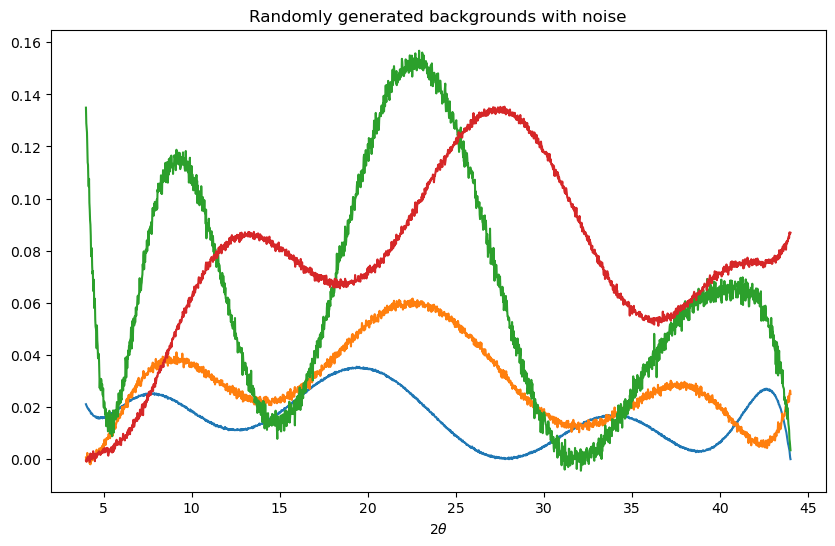

In [25]:
import matplotlib.pyplot as plt

data = torch.linspace(4,44,2048).float()

batchsize = 4
bgs = get_background(batchsize, data, degree=10)
bgs -= bgs.min(dim=-1).values.unsqueeze(1)

noise = get_noise(bgs)

fig, ax = plt.subplots(1,1,figsize=(10,6))
for bg in (bgs+noise):
    ax.plot(data, bg)
ax.set_xlabel("$2\\theta$")
ax.set_title("Randomly generated backgrounds with noise")
plt.show()

Some funky background shapes are possible with randomly generated Chebyshev polynomials! We can also see varying levels of noise being added to the profiles.

We now need functions to tie everything together and start to generate some data

In [26]:
def get_peak_positions(crystal_systems, hkl, intensities, unit_cells,
                    perturbation_stddev=0.05, zpemin=0.03, zpemax=0.03, wavelength=1.54056):
    batchsize = intensities.shape[0]
    dtype = intensities.dtype
    device = intensities.device

    cell_perturbation = get_unit_cell_perturbation(crystal_systems,
                                    dtype=dtype, stddev=perturbation_stddev)
    new_unit_cells = unit_cells + cell_perturbation
    lattice_matrix, valid = get_lattice_matrix(new_unit_cells)

    # Get rid of any invalid unit cells after perturbation
    if valid.sum() != valid.shape[0]:
        import warnings
        warnings.warn("Invalid cells generated")
        lattice_matrix = lattice_matrix[valid]
        hkl = hkl[valid]
        intensities = intensities[valid]
        batchsize = intensities.shape[0]
    reciprocal_lattice_matrix = torch.linalg.inv(lattice_matrix)
    reciprocal_lattice_metric_tensor = get_recip_lattice_metric_tensor(reciprocal_lattice_matrix)
    d_spacing = get_d_spacing(reciprocal_lattice_metric_tensor, hkl)
    zpe = get_zero_point_error(batchsize, device, dtype, zpemin=zpemin, zpemax=zpemax)
    twotheta = zpe + d_to_tt(d_spacing, wavelength)

    return twotheta, reciprocal_lattice_metric_tensor, hkl, intensities, d_spacing

def get_PO_intensities(hkl, reciprocal_lattice_metric_tensor, dspacing, intensities, PO_std=0.1):
    # Now apply PO perturbation to the peak intensities
    cosP, sinP, MDfactor, PO_axis = get_MD_PO_components(hkl,
                                    reciprocal_lattice_metric_tensor, dspacing, factor_std=PO_std)
    intensities = apply_MD_PO_correction(intensities, cosP, sinP, MDfactor)
    return torch.nan_to_num(intensities)

def get_peak_shape_params(twotheta, U_min=0.0001, U_max=0.0004,
                        V_min=0.0001, V_max=0.0004, W_min=0.0001, W_max=0.0004,
                        Z_min=0.0001, Z_max=0.0004, X_min=0.001, X_max=0.035,
                        Y_min=0.001, Y_max=0.035, shlmax=0.5):
    batchsize = twotheta.shape[0]
    dtype = twotheta.dtype
    device = twotheta.device
    tan_twotheta = torch.tan(twotheta*torch.pi/180.)
    cos_twotheta = torch.cos(twotheta*torch.pi/180.)
    U, V, W, Z = get_UVWZ(batchsize, device, dtype, U_min=U_min, U_max=U_max,
                        V_min=V_min, V_max=V_max, W_min=W_min, W_max=W_max,
                        Z_min=Z_min, Z_max=Z_max)
    X, Y = get_XY(batchsize, device, dtype, X_min=X_min, X_max=X_max,
                        Y_min=Y_min,Y_max=Y_max)
    hwhm_gaussian = get_hwhm_G(tan_twotheta, cos_twotheta, U, V, W, Z)
    hwhm_lorentzian = get_hwhm_L(tan_twotheta, cos_twotheta, X, Y)
    shl = get_shl(batchsize, device, dtype, shlmax=shlmax, rescale=True)
    return hwhm_gaussian, hwhm_lorentzian, shl

def calculate_peaks(x, twotheta, intensities, hwhm_gaussian, hwhm_lorentzian, shl):
    peak_G =  gaussian(x, torch.zeros_like(twotheta), hwhm_gaussian)
    peak_L = lorentzian(x, torch.zeros_like(twotheta), hwhm_lorentzian)
    peak_FCJ = fcj(x,twotheta, shl)
    peak_GLF = torch.stack([peak_G,peak_L,peak_FCJ],dim=1)
    prod_FT_GLF = torch.fft.fft(peak_GLF).prod(dim=1)
    peak_voigt = torch.fft.ifft(prod_FT_GLF).real
    zero_sum = peak_FCJ.sum(dim=-1) == 1
    peak_voigt[zero_sum.squeeze()] = torch.fft.ifftshift(peak_voigt[zero_sum.squeeze()], dim=-1)
    peak_voigt /= peak_voigt.max(dim=2).values.unsqueeze(2)
    peak_voigt *= intensities
    return peak_voigt

def calculate_full_patterns(x, full_data, twotheta, peak_voigt, ttmin=4., ttmax=44.):
    # Finally calculate the full diffraction pattern
    twotheta[twotheta == 0] = torch.inf
    twotheta[twotheta < 4] = torch.inf
    twotheta[twotheta > 44] = torch.inf
    peakidx = torch.abs((x[0] + twotheta) - full_data).min(dim=-1).indices
    full_pattern = torch.zeros(list(peakidx.shape)+[full_data.shape[0]], device=device, dtype=dtype)
    full_pattern = full_pattern.scatter_(2,
                    peakidx.unsqueeze(2) + torch.arange(x.shape[0], device=device), peak_voigt*torch.isfinite(twotheta))

    full_pattern = full_pattern.sum(dim=1)
    full_pattern /= full_pattern.max(dim=1).values.unsqueeze(1)
    full_pattern = full_pattern[:,(full_data >= ttmin) & (full_data <= ttmax)]
    return full_pattern

def calculate_diffraction_patterns(x, full_data, crystal_systems, hkl, intensities, unit_cells, wavelength=1.54056):
    """
    Expect the input tensors to have their first dimension to be of size batchsize
    """

    twotheta, reciprocal_lattice_metric_tensor, hkl, intensities, d_spacing = get_peak_positions(crystal_systems, hkl, intensities, unit_cells,
                    perturbation_stddev=0.05, zpemin=0.03, zpemax=0.03, wavelength=wavelength)

    twotheta = twotheta.unsqueeze(2)

    mod_intensities = get_PO_intensities(hkl, reciprocal_lattice_metric_tensor, d_spacing, intensities).unsqueeze(2)

    hwhm_gaussian, hwhm_lorentzian, shl = get_peak_shape_params(twotheta)

    peak_voigt = calculate_peaks(x, twotheta, mod_intensities, hwhm_gaussian, hwhm_lorentzian, shl)

    calculated_patterns = calculate_full_patterns(x, full_data, twotheta, peak_voigt, ttmin=ttmin, ttmax=ttmax)

    bgs = get_background(calculated_patterns.shape[0], 
                        full_data[(full_data >= ttmin) & (full_data <= ttmax)],
                        degree=10)
    noise = get_noise(calculated_patterns)

    calculated_patterns += bgs + noise
    calculated_patterns -= calculated_patterns.min(dim=1).values.unsqueeze(1)
    calculated_patterns /= calculated_patterns.max(dim=1).values.unsqueeze(1)

    return calculated_patterns

Let's test the functions we've written using some real diffraction data as a comparison point. We'll first plot the actual diffraction pattern, then plot several simulated datasets calculated from the unit cell, hkls and intensities extracted by DASH. This will show the effect of the data augmentation we've added into the code which modulates the positions, intensities and shapes of the peaks.

The dataset we'll look at is that for verapamil hydrochloride. We'll need a function to calculate the Lorentz-polarisation factor for the intensities, as this would have been corrected for in the intensities in the DASH hcv.

In [27]:
v_xye = []
with open("./files/Verap.xye", "r") as f:
    for line in f:
        line = list(filter(None, line.strip().split(" ")))
        v_xye.append([float(x) for x in line])
v_xye = np.array(v_xye)
v_tt, v_i_obs = v_xye[:,0], v_xye[:,1]
v_i_obs /= v_i_obs.max()

In [28]:
def lp_factor(twotheta, ttmono=torch.tensor([28])):
    A = torch.cos(ttmono*torch.pi/180)**2
    cossqdtt = torch.cos(twotheta*torch.pi/180)**2
    sintt = torch.sin(twotheta*torch.pi/180)
    return (1+A*cossqdtt) / ((1+A)*sintt)

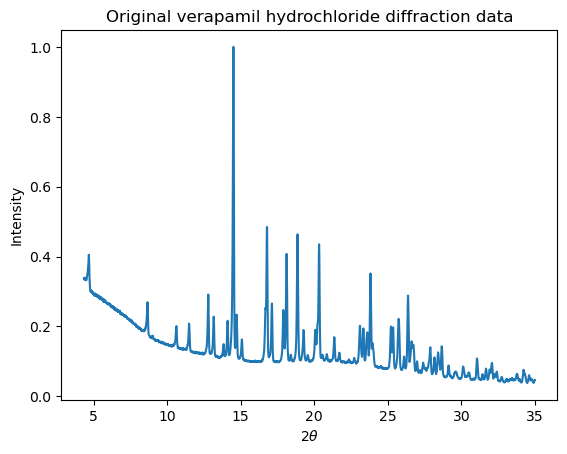

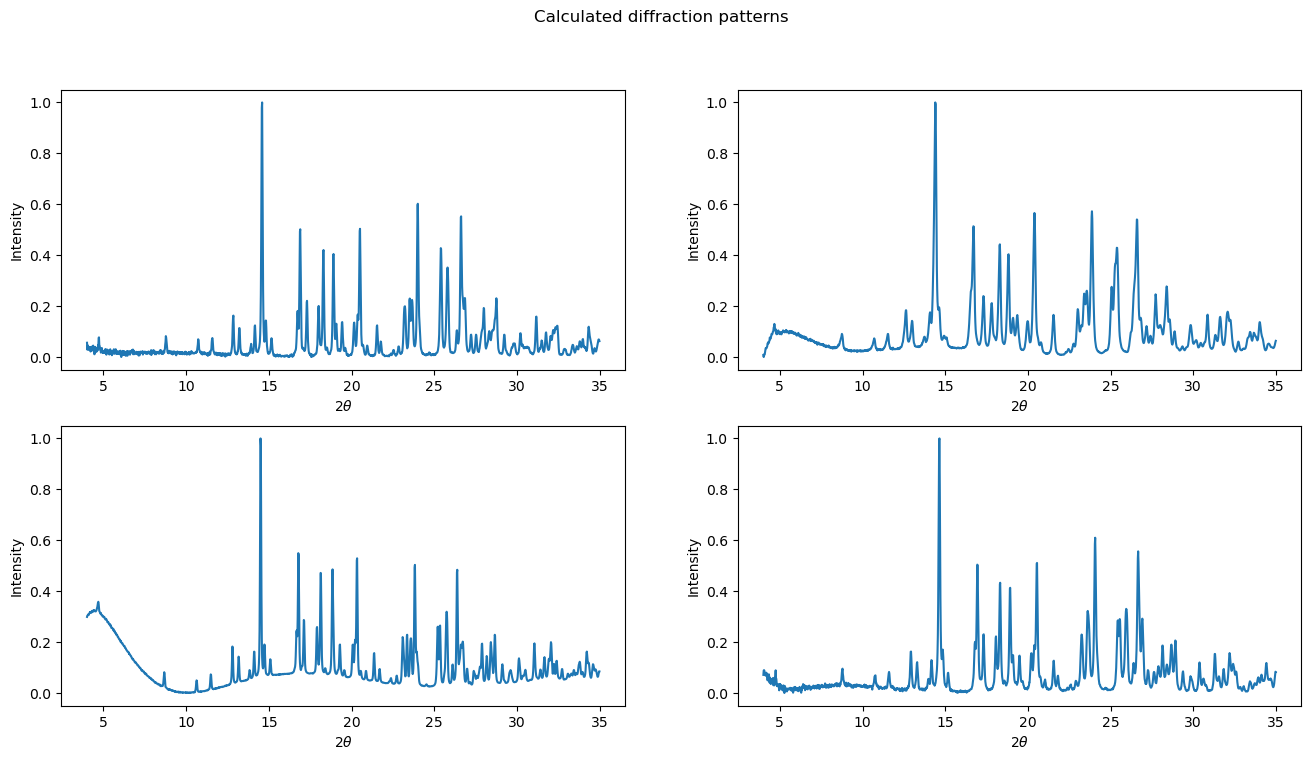

In [32]:
import matplotlib.pyplot as plt
device = torch.device("cpu")
dtype = torch.float32
ttmin = 4
ttmax = 44
peakrange = 3.
datadim = 2048
full_data = torch.linspace(ttmin-(peakrange/2), ttmax+(peakrange/2), int(np.ceil((ttmax-ttmin+peakrange)/((ttmax-ttmin)/datadim))), device=device, dtype=dtype)
plotdata = full_data[(full_data >= ttmin) & (full_data <= ttmax)].cpu()
x = (full_data[full_data <= ttmin+(peakrange/2)]).clone() - 4

v_hkl = []
v_i = []
with open("./files/Verap.hcv", "r") as f:
    for line in f:
        line = list(filter(None, line.strip().split(" ")))
        v_hkl.append([int(x) for x in line[0:3]])
        v_i.append(float(line[3]))
v_hkl = torch.tensor(v_hkl).float()
v_i = torch.tensor(v_i).float()
v_cell = torch.tensor([7.08991, 10.59464, 19.20684, 100.1068, 93.7396, 101.5610])
v_cs = torch.tensor([cs_key["Monoclinic"]])

repeat = 4
diffraction_patterns = calculate_diffraction_patterns(x, full_data, v_cs.repeat(repeat), v_hkl.repeat(repeat,1,1), v_i.repeat(repeat,1), v_cell.repeat(repeat,1))
plt.plot(v_tt[v_tt <= 35], v_i_obs[v_tt <= 35])
plt.title("Original verapamil hydrochloride diffraction data")
plt.xlabel("$2\\theta$")
plt.ylabel("Intensity")
plt.show()
fig, ax = plt.subplots(2,2,figsize=(16,8))
for i, p, in enumerate(diffraction_patterns):
    col = i % 2
    row = i // 2
    corrected_i = (lp_factor(plotdata[plotdata <= 35])*p[plotdata <= 35]).squeeze()
    corrected_i -= corrected_i.min()
    corrected_i /= corrected_i.max()
    ax[row][col].plot(plotdata[plotdata <= 35], corrected_i)
    ax[row][col].set_xlabel("$2\\theta$")
    ax[row][col].set_ylabel("Intensity")
fig.suptitle("Calculated diffraction patterns")
plt.show()

The calculated patterns clearly resemble the observed diffraction data, whilst also having subtle differences in the background, noise levels, peak shapes, peak asymmetries as well as the peak positions and intensities.

# Performance
Let's test the performance of the generation code on an Nvidia Quadro RTX 5000 GPU (16 GB VRAM). We've got about 288k patterns to generate, how long will it take?!

In [33]:
data_dir = "./"
base_name = "4-44-CuKa1-data_4000_"
crystal_systems = torch.tensor(np.load(data_dir+base_name+"crystal_systems_numeric.npy"))
hkl             = torch.tensor(np.load(data_dir+base_name+"hkl.npy")).float()
intensities     = torch.tensor(np.load(data_dir+base_name+"intensities.npy")).float()
unit_cell       = torch.tensor(np.load(data_dir+base_name+"unit_cell.npy")).float()
cod_id         = np.load(data_dir+base_name+"cod_id.npy")

In [35]:
from tqdm import tqdm

device = torch.device("cuda:0")
dtype = torch.float32
ttmin = 4
ttmax = 44
peakrange = 3.
datadim = 2048
full_data = torch.linspace(ttmin-(peakrange/2), ttmax+(peakrange/2), int(np.ceil((ttmax-ttmin+peakrange)/((ttmax-ttmin)/datadim))), device=device, dtype=dtype)
plotdata = full_data[(full_data >= ttmin) & (full_data <= ttmax)]
x = (full_data[full_data <= ttmin+(peakrange/2)]).clone() - ttmin

batchsize = 1000
idx = torch.arange(batchsize)

for i in tqdm(range(intensities.shape[0]//batchsize)):
    batch_idx = idx + (i*batchsize)
    diffraction_patterns = calculate_diffraction_patterns(
                                        x,
                                        full_data,
                                        crystal_systems[batch_idx].to(device),
                                        hkl[batch_idx].to(device),
                                        intensities[batch_idx].to(device),
                                        unit_cell[batch_idx].to(device)
                                    )

100%|██████████| 288/288 [00:57<00:00,  4.97it/s]


288k patterns generated in about a minute - this means we can generate about 5000 diffraction patterns per second!

I'm sure there are some tweaks that would boost the performance even more, but for now this will be good enough for initial experiments with neural networks. A quick check with a profiler could give some hints as to where the biggest bottlenecks in the code are:

In [40]:
import cProfile as profile
import pstats

prof = profile.Profile()
prof.enable()
diffraction_patterns = calculate_diffraction_patterns(
                                        x,
                                        full_data,
                                        crystal_systems[batch_idx].to(device),
                                        hkl[batch_idx].to(device),
                                        intensities[batch_idx].to(device),
                                        unit_cell[batch_idx].to(device)
                                    )
prof.disable()
stats = pstats.Stats(prof).strip_dirs().sort_stats("tottime")
stats.print_stats(10) # top 10 rows

         294 function calls in 0.422 seconds

   Ordered by: internal time
   List reduced from 94 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.297    0.297    0.298    0.298 118587661.py:54(calculate_peaks)
        1    0.086    0.086    0.086    0.086 118587661.py:67(calculate_full_patterns)
        4    0.016    0.004    0.016    0.004 {method 'to' of 'torch._C._TensorBase' objects}
        1    0.015    0.015    0.016    0.016 1250221022.py:1(get_MD_PO_components)
        1    0.002    0.002    0.422    0.422 3294103451.py:6(<module>)
        1    0.002    0.002    0.004    0.004 118587661.py:1(get_peak_positions)
        1    0.000    0.000    0.000    0.000 {built-in method torch._C._linalg.linalg_inv}
        1    0.000    0.000    0.001    0.001 895306903.py:3(get_unit_cell_perturbation)
        1    0.000    0.000    0.405    0.405 118587661.py:82(calculate_diffraction_patterns)
        1    0.000    0.00

The filenames look a bit odd as I'm running this in a notebook. However, it looks like the peak calculation is taking the most time, which isn't too surprising to me as there's a lot going on there! Perhaps in future work I'll try to improve the efficiency of the code. For now though, I think it's good enough for us to start experimenting with training neural networks, which will be the subject of future posts.

# PowCod generated data

As a final sense check, let's see some of the data we can generate from the PowCod database

1 - http://www.crystallography.net/cod/7220223.html
2 - http://www.crystallography.net/cod/1553394.html
3 - http://www.crystallography.net/cod/7037807.html
4 - http://www.crystallography.net/cod/7036591.html


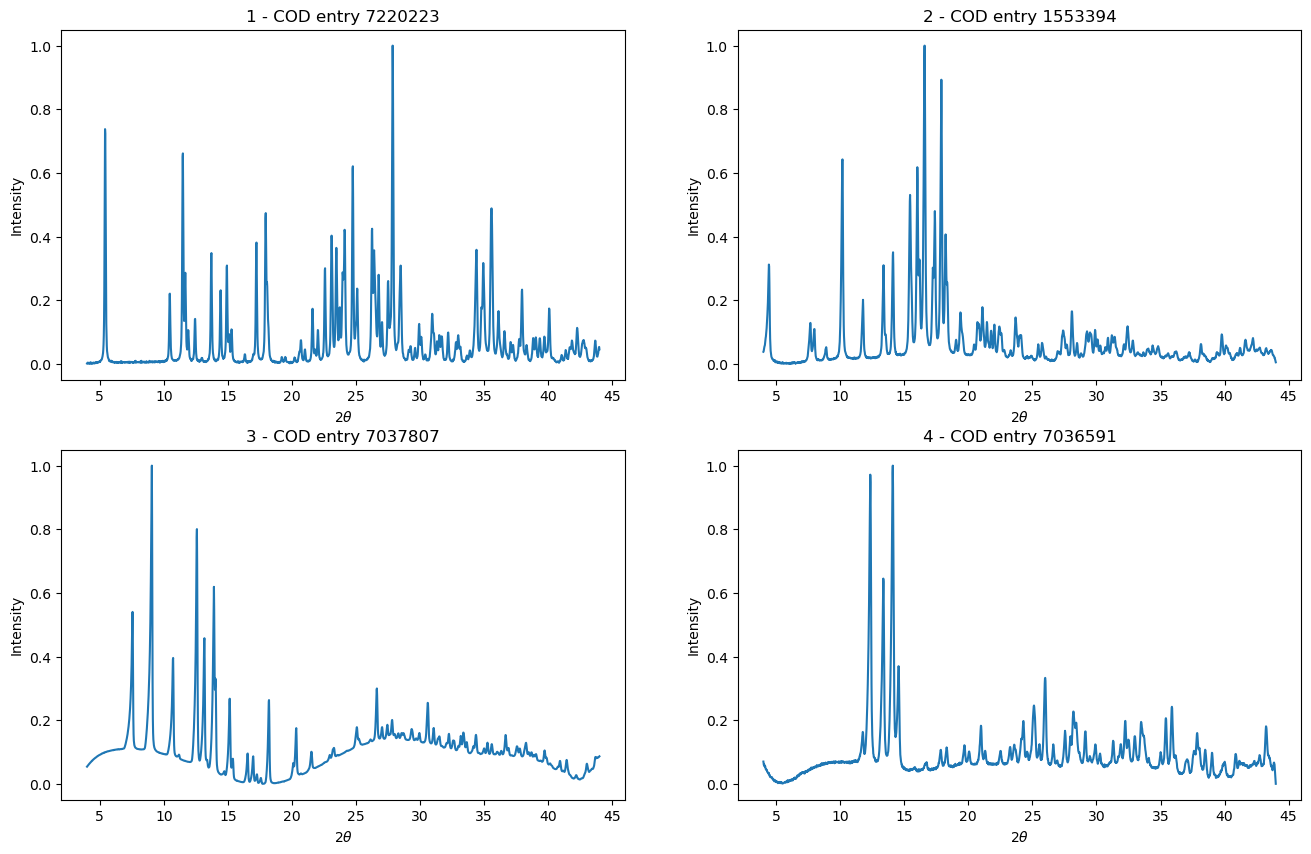

In [48]:
idx = torch.arange(4)
diffraction_patterns = calculate_diffraction_patterns(
                                        x,
                                        full_data,
                                        crystal_systems[idx].to(device),
                                        hkl[idx].to(device),
                                        intensities[idx].to(device),
                                        unit_cell[idx].to(device)
                                    )
fig, ax = plt.subplots(2,2,figsize=(16,10))
for i, d in enumerate(diffraction_patterns):
    col = i % 2
    row = i // 2
    ax[row][col].plot(plotdata.cpu().numpy(), d.cpu().numpy())
    ax[row][col].set_xlabel("$2\\theta$")
    ax[row][col].set_ylabel("Intensity")
    ax[row][col].set_title(f"{i+1} - COD entry {cod_id[idx[i]]}")
    print(f"{i+1} - http://www.crystallography.net/cod/{cod_id[idx[i]]}.html")
plt.show()

I downloaded the CIFs for each of the COD entries, and calculated their diffraction patterns using Mercury. I am very pleased that the patterns produced by the code in this post match the patterns produced by Mercury!

# Conclusions

In this post, we've developed some code to allow us to read in unit cells, Miller indices, crystal system information and intensities, and rapidly generate realistic looking powder X-ray diffraction data on a GPU.

I've put all the functions written in this code into a github repository which can be found here - [https://github.com/mspillman/powcodgen/](https://github.com/mspillman/powcodgen/) - please feel free to submit issues, pull requests etc if you have any ideas or suggestions for improvement!

In future posts, I'll show how such data can be used to train artificial neural networks to do lots of interesting and useful things to help crystallographers understand their data.